# Redes neuronales recurrentes


## Predicción de series ordenadas en el tiempo

En esta clase vamos a trabajar con una serie de tiempo. El objetivo es hacer una predicción del precio de la acción de Apple con 7 días de anticipación, en base a una serie histórica.

Para esto utilizaremos RNNs.

### Parte 1: Carga de datos
Primero se debe cargar una serie histórica. Cargaremos una serie con el precio de la acción de Apple de 140 días. Luego se hará un pre-procesamiento para utilizar la información con un modelo de una RNN.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Descargamos los datos
! git clone https://bitbucket.org/botiaio/campusparty_applestock.git

Cloning into 'campusparty_applestock'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 1.77 KiB | 908.00 KiB/s, done.


In [2]:
### Cargamos el dataset en un array de numpy
dataset = np.loadtxt('campusparty_applestock/normalized_apple_prices.csv')

Observemos los datos cargados

Text(0, 0.5, 'serie normalizada')

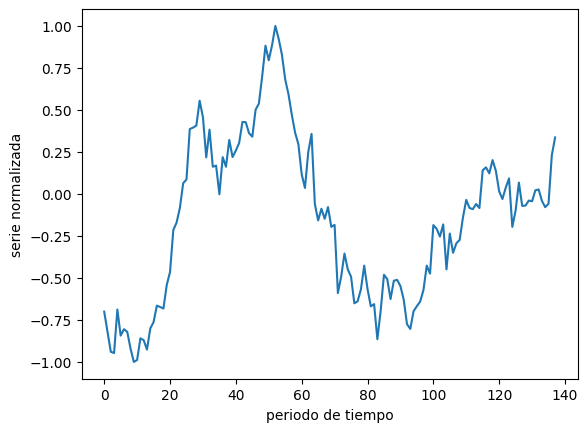

In [3]:
plt.plot(dataset)
plt.xlabel('periodo de tiempo')
plt.ylabel('serie normalizada')

### Parte 2: Cortar la serie ordenada en secuencias

Generalmente se representa matemáticamente una serie ordenada como:

$$s_{0},s_{1},s_{2},...,s_{P}$$


donde $s_{p}$ es el valor numérico de la serie en el intervalo de tiempo $p$ , siendo  $P$ el largo total de la serie. Para aplicar el RNN, en este caso se debe tratar a la predicción como un problema de regresión. Para ello se debe usar una *"ventana móvil"* para construir un set asociado de pares de entrada-salida sobre los cuales aplicar la regresión.

Por ejemplo, para una ventana de tamaño T = 3 se deben producir los siguientes pares:

$$\begin{array}{c|c}
\text{X (input)} & \text{y(output)}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$


#### Ventana móvil
Completar la función llamada **window_transform_series** que ejecuta una ventana móvil a lo largo de una serie de datos y crea los pares de input y output necesarios para el entrenamiento.

La función recibe la serie de datos (un array de números) y el tamaño de la ventana (3 en el ejemplo de arriba).

 Se debe retornar dos numpy arrays: X e y.

In [4]:
def window_transform_series(series, window_size):
    X = []
    y = []

    for i in range(window_size, len(series)):
      data_slice = series[i-window_size : i]
      target = series[i]

      X.append(data_slice)
      y.append(target)

    # Código auxiliar que puede ser necesario (si no lo necesitan, pueden borrarlo)
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

Se puede probar la función con los datos de debajo:

### Probar la función window_transform_series
A continuación probar el código recién programado.

In [5]:
test_series = np.arange(30)

Utilizar una ventana de tamaño 2 y obtener el siguiente número de la serie

In [6]:
window_size = 2
X,y = window_transform_series(test_series, 2)

In [7]:
print ('El input X es:')
print (X)

print ('El output y asociado es:')
print (y)

El input X es:
[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]
 [10 11]
 [11 12]
 [12 13]
 [13 14]
 [14 15]
 [15 16]
 [16 17]
 [17 18]
 [18 19]
 [19 20]
 [20 21]
 [21 22]
 [22 23]
 [23 24]
 [24 25]
 [25 26]
 [26 27]
 [27 28]]
El output y asociado es:
[[ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]]


Una vez que la función de arriba funcione correctamente, aplicarla con una ventana de tamaño 7 al juego de datos cargados.



In [8]:
window_size = 7
X,y = window_transform_series(dataset, window_size)

Comprobamos que el largo de X sea igual al de y

In [9]:
assert np.shape(X)[0] == np.shape(y)[0]

###Parte 3: Separar los datos en datos de entrenamiento y de test


Para separar los datos en train y test, al tratarse de una serie de tiempo (que sigue un orden de secuencia) no se debe utilizar un split aleatorio como por ejemplo train_test_split de sklearn.

Tomar un 70% de los datos para entrenar la red neuronal y dejar el 30% restante para evaluar la misma.

In [10]:
# Separar los datos en entrenamiento y test
train_test_split = int(len(X) * 0.7) # 70% train

# Partir los datos
X_train = X[:train_test_split]
y_train = y[:train_test_split]

# Mantener la última parte para test
X_test = X[train_test_split:]
y_test = y[train_test_split:]

In [11]:
# IMPORTANTE: para utilizar el módulo RNN LSTM de Keras el input debe tener la forma [samples, window size, stepsize]
#Estas transformaciones se hacen a continuación
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [12]:
X_train.shape

(91, 7, 1)

In [13]:
X_test.shape

(40, 7, 1)

###Parte 4: Crear y ejecutar un modelo de regresión utilizando RNN

Se utilizará una red neuronal con dos capas ocultas RNN con las siguientes especificaciones:

* La capa 1 debe usar un módulo LSTM con 5 unidades ocultas. ¿Cómo debe ser el input shape?

* La capa 2 usa un módulo completamente conectado (fully connected) con una unidad

* Como loss function, entre las siguientes 2 opciones:
  - mean_squared_error
  - categorical_cross_entropy

¿Cuál les sirve? ¿Por qué?

* Utilizar Adam como optimizador (learning rate de 0.01)

In [14]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

#Crear el modelo secuencial
model = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model.add(LSTM(units=5, input_shape=(window_size, 1)))
#Agregar una capa densa con una unidad
model.add(Dense(1))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Compilar el modelo con la función de pérdida requerida
model.compile(optimizer=optimizer, loss='mse')

La red neuronal que definió es una red neuronal recurrente del tipo LSTM (Long short term memory). Todas las RNN (RNN, GRU, LSTM) tienen una retroalimentación en las capas recurrentes, esto es lo que les permite mantener información a lo largo del tiempo (una especie de "memoria"). Sin embargo, las RNN estandar sufren de un problema conocido como vanishing gradient. Esto quiere decir que no son buenas para resolver problemas en los cuales necesitan mantener información por largos periodos de tiempo (por ejemplo, secuencias de texto largas o series de tiempo). Esto es porque el gradiente de la loss function decae exponencialmente con el tiempo.

Las LSTM son un tipo de rnn que tienen una celda de memoria que puede mantener información por largos periodos de tiempo. Esto hace que sean más útiles a la hora de resolver problemas como el que se está trabajando en este caso.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenar el modelo con los datos separados para esta función haciendo uso de la función fit.

Sugerencia: Investigar y probar con distintos valores de epochs y tamaño de batch.


In [16]:
history = model.fit(X_train,
          y_train,
          validation_data=(X_test, y_test),
          batch_size=16,
          verbose=0,
          epochs=50)

Graficamos el MSE en train y test por epoch de entrenamiento:

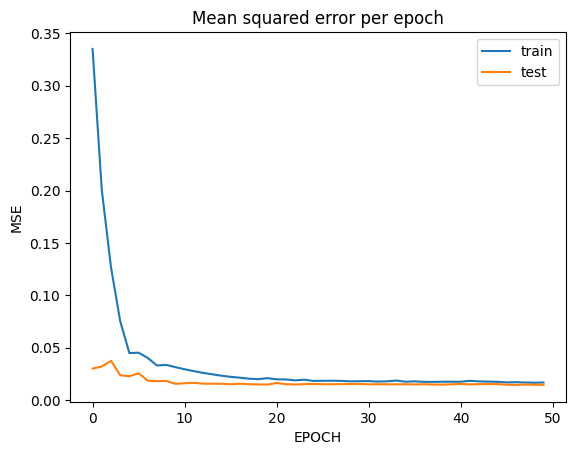

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean squared error per epoch')
plt.ylabel('MSE')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'])
plt.show()

¿Conclusiones?

###Parte 5: Medir la performance del modelo
Ahora estamos en condiciones de hacer una predicción

In [18]:
# Hacer la predicción con el modelo entrenado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 12ms/step


In [19]:
train_predict.shape

(91, 1)

In [20]:
X_train.shape

(91, 7, 1)

Se debería obtener un error sobre los datos de entrenamiento como de test menor a 0.02. Si no se consigue este valor, se puede aumentar el número de epochs y re-entrenar el modelo o ajustar el tamaño del batch.

In [21]:
# Medir la precisión
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Error de test = ' + str(testing_error))

Error de entrenamiento = 0.016426237300038338
Error de test = 0.01460864208638668


Ahora grafiquemos los datos:

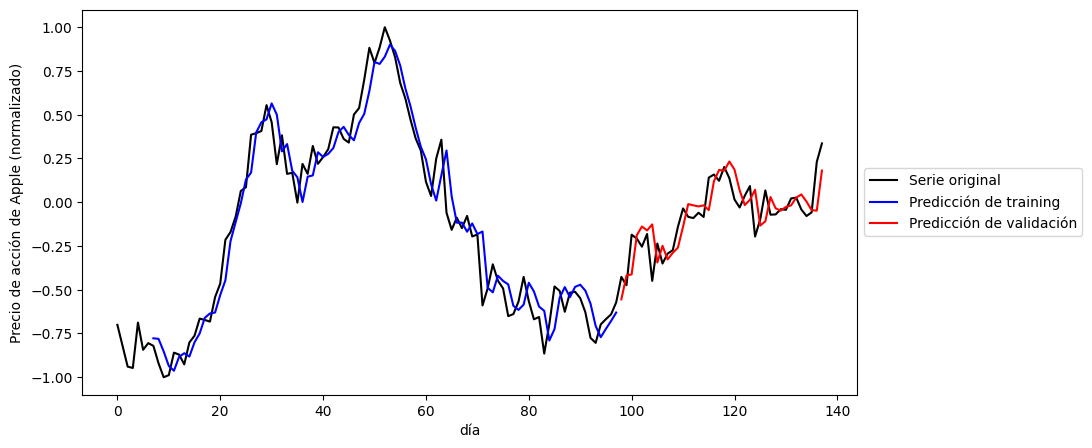

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = train_test_split + window_size
plt.plot(np.arange(window_size, split_pt, 1), train_predict, color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt, split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()